<div style="text-align:center; margin-top:8px; margin-bottom:18px;">
  <div style="font-size:52px; font-weight:800; line-height:1.15;">
    NIH Grant Activity Classifier
  </div>

  <div style="font-size:22px; font-weight:600; margin-top:16px;">
    Erica Zhao, Crystal Kao
  </div>

  <div style="font-size:14px; color:#777; margin-top:10px;">
    Portfolio Version
  </div>
</div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Environment Setup" data-toc-modified-id="Environment Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Environment Setup</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Hyperparameter-Tuning" data-toc-modified-id="Hyperparameter-Tuning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hyperparameter Tuning</a></span></li><li><span><a href="#Model-Selection" data-toc-modified-id="Model-Selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Selection</a></span></li><li><span><a href="#Generating-the-Submission-File" data-toc-modified-id="Generating-the-Submission-File-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Generating the Submission File</a></span><ul class="toc-item"><li><span><a href="#Creating-the-directory-for-the-submission-file" data-toc-modified-id="Creating-the-directory-for-the-submission-file-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Creating the directory for the submission file</a></span></li><li><span><a href="#Generating-the-submission-file" data-toc-modified-id="Generating-the-submission-file-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Generating the submission file</a></span></li></ul></li><li><span><a href="#Interpretation" data-toc-modified-id="Interpretation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Interpretation</a></span><ul class="toc-item">
</ul></li><li><span><a href="#reference" data-toc-modified-id="Reference-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Reference</a></span><ul class="toc-item">

# Introduction

Scientific and medical research have long been an important part of society, and the U.S. has invested heavily in public health through the National Institutes of Health (NIH). The NIH is a government agency under the United States Department of Health and Human Services. Within the NIH, there are 27 institutes and centers (ICs) that each specialize in a different subject area or function. Each of these institutes oversees funding and managing research related to their subject area. In 2023, the NIH was given a budget of $48 billion, 83% of which was given out to institutions across the country.

This project was informed by input from a former NIH employee and uses only publicly available NIH RePORTER data. We thought it would be interesting to take a closer look at what the NIH currently funds across award mechanisms and institutes from a public-interest perspective, and the results may be useful for researchers and data analysts studying patterns in NIH-funded awards.

The main objective of this analysis is to build a multi-class model that predicts NIH award activity series from structured award signals (e.g., cost fields, institute/center, and support year). A description of the fields is provided in the following section.

# Data Description

The data for this analysis comes from NIH RePORTER, a public database of awarded grants.

We pulled 6 fiscal years of award records (FY2018–FY2023), totaling 118,355 grants. (FY = fiscal year; October–September.)

The raw export contains up to 52 columns. The key fields used in this project are:

- **Activity (target):** NIH activity code (e.g., R01, U01, K99) mapped to activity series **F/T/K/R**.
- **Total Cost:** overall cost of the award.
- **Direct Cost IC:** direct research costs provided to the recipient.
- **Indirect Cost IC:** indirect/overhead costs (e.g., facilities and administrative support).
- **Total Cost IC:** total cost attributed to an institute/center (IC), since some awards are co-funded.
- **Support Year:** number of years the grant has been funded.

# Environment Setup

## Random seed

In [ ]:
# Reproducibility
SEED = 42
import numpy as np
np.random.seed(SEED)

try:
    import tensorflow as tf
    tf.random.set_seed(SEED)
except Exception:
    pass

# Data Preprocessing

In this section, we clean the award records and prepare features for modeling. This includes standardizing key fields, handling missing values, and creating train/validation splits for model development.

In [ ]:
import pandas as pd

# Load data
df_raw_train = pd.read_csv("data/processed/train.csv")
df_raw_test  = pd.read_csv("data/processed/test.csv")
df_raw_all   = pd.read_csv("data/raw/FY18-FY22_NIH_Awards.csv")

# Working copies
df_train = df_raw_train.copy(deep=True)
df_test  = df_raw_test.copy(deep=True)

## Data Exploration/Visualization

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

sns.set()

In [9]:
# Combine df_train, df_val and df_test
df_comb = pd.concat([df_train, df_test], sort=False)

In [10]:
# creating target variable
df_comb["act_type"] = df_comb['Activity'].astype(str).str[0]

# fill in blanks (these blanks actually had spaces)
df_comb.replace(' ', pd.NA, inplace=True)

# convert cost fields to integers
df_comb[['Total Cost', 'Direct Cost IC', 'InDirect Cost IC', 'Total Cost IC']] = df_comb[['Total Cost', 'Direct Cost IC', 'InDirect Cost IC', 'Total Cost IC']].apply(pd.to_numeric)

# convert support year to integer
df_comb[['Support Year']] = df_comb[['Support Year']].apply(pd.to_numeric)

# Call nan_checker on df
df_nan = nan_checker(df_comb)

# Get the variables with missing values, their proportion of missing values and data type
df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)

# If there are missing values
if len(df_miss['var']) > 0:
    # The SimpleImputer
    si = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Impute the variables with missing values in df_train, df_val and df_test
    df_comb[df_miss['var']] = si.fit_transform(df_comb[df_miss['var']])

Text(0, 0.5, 'Awards')

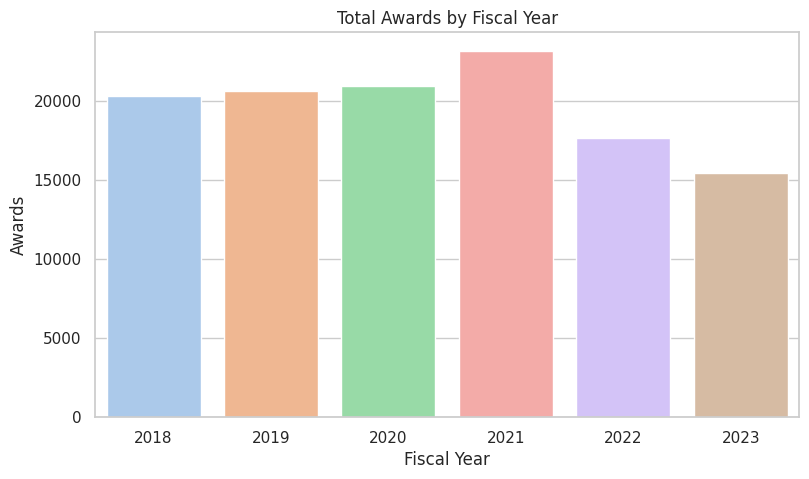

In [11]:
# Plotting Total awards by fiscal year
awards_by_year = df_comb['Fiscal Year'].value_counts().sort_index()
total_cost_by_year = df_comb.groupby('Fiscal Year')['Total Cost'].sum()/1000000

plt.figure(figsize=(20, 5))
sns.set_style('whitegrid')

plt.subplot(1, 2, 1)
sns.barplot(x=awards_by_year.index, y=awards_by_year.values, palette='pastel')
plt.title('Total Awards by Fiscal Year')
plt.xlabel('Fiscal Year')
plt.ylabel('Awards')

Text(0, 0.5, 'Dollars Awarded ($M)')

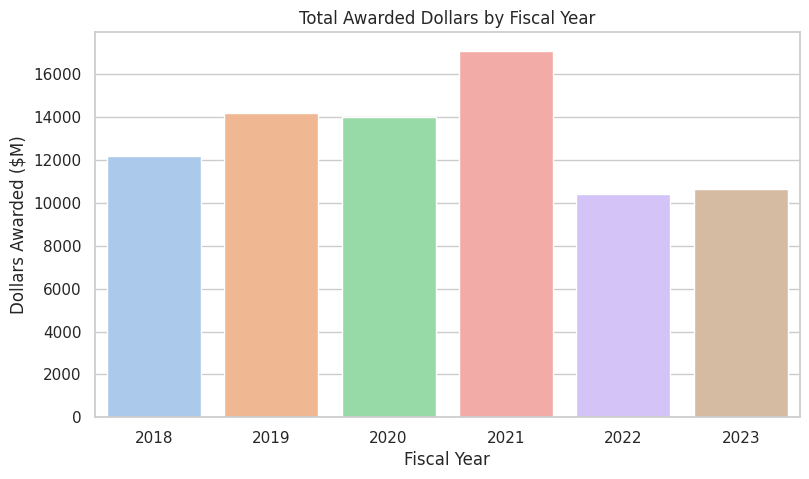

In [12]:
# Plotting Total awarded dollars by fiscal year

plt.figure(figsize=(20, 5))
sns.set_style('whitegrid')

plt.subplot(1, 2, 2)
sns.barplot(x=total_cost_by_year.index, y=total_cost_by_year.values, palette='pastel')
plt.title('Total Awarded Dollars by Fiscal Year')
plt.xlabel('Fiscal Year')
plt.ylabel('Dollars Awarded ($M)')

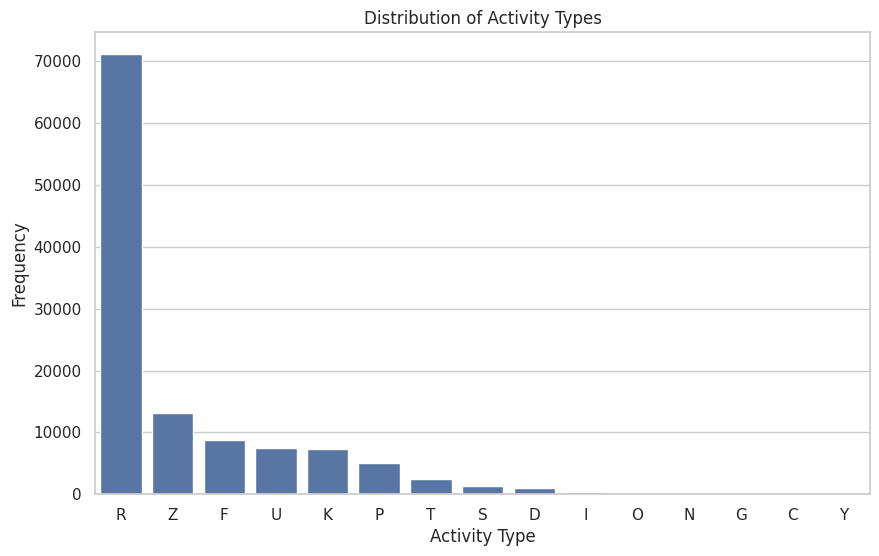

In [13]:
# Plotting the distribution of activity types

plt.figure(figsize=(10, 6))
sns.countplot(x='act_type', data=df_comb, order=df_comb['act_type'].value_counts().index)
plt.title('Distribution of Activity Types')
plt.xlabel('Activity Type')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Administering IC')

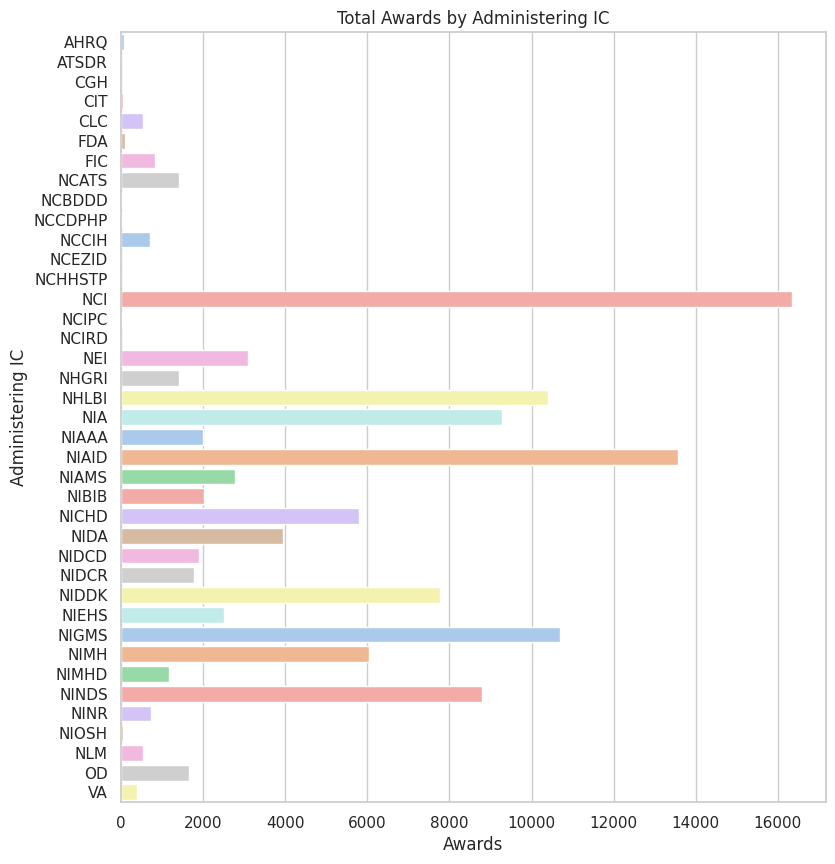

In [14]:
# Plotting Total awards by Administering_IC
award_by_ic = df_comb['Administering IC'].value_counts().sort_index()
cost_by_ic = df_comb.groupby('Administering IC')['Total Cost'].sum()/1000000

plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')

plt.subplot(1, 2, 1)
sns.barplot(x=award_by_ic.values, y=award_by_ic.index, palette='pastel')
plt.title('Total Awards by Administering IC')
plt.xlabel('Awards')
plt.ylabel('Administering IC')

Text(0, 0.5, 'Administering IC')

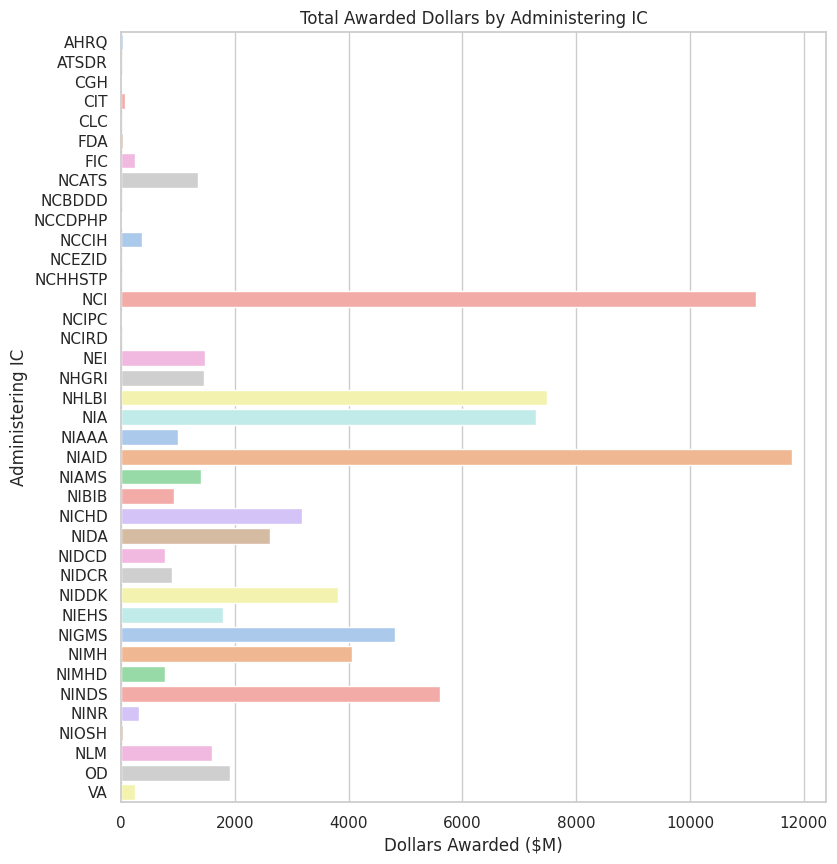

In [15]:
# Plotting Total awarded dollars by administering IC

plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')

plt.subplot(1, 2, 2)
sns.barplot(x=cost_by_ic.values, y=cost_by_ic.index, palette='pastel')
plt.title('Total Awarded Dollars by Administering IC')
plt.xlabel('Dollars Awarded ($M)')
plt.ylabel('Administering IC')

# Data Cleaning

In [16]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,102861,36


In [17]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,15494,52


In [18]:
# Print the first 5 rows of df_train
df_train.head()

,NIH Spending Categorization,Project Terms,Project Title,Public Health Relevance,Administering IC,Application ID,FOA,Project Number,Type,Activity,...,Organization Country,Funding Mechanism,Fiscal Year,Total Cost,Total Cost (Sub Projects),Funding IC(s),Direct Cost IC,InDirect Cost IC,NIH COVID-19 Response,Total Cost IC
0,No NIH Category available,Adipocytes;Adipose tissue;Affect;Affinity;Amin...,Elucidating novel molecular mechanisms of iris...,PROJECT NARRATIVE:\nInactive lifestyle leads t...,NIDDK,10464471,PA-21-048,1F32DK132864-01,1,F32,...,UNITED STATES,"Training, Individual",2022,67582,,NIDDK,67582,0,,67582
1,No NIH Category available,3-Dimensional;Address;Affect;Algorithms;Attent...,Mobile Three-Dimensional Screening for Cranial...,NARRATIVE\n Delayed identification of infant h...,NIDCR,10482547,PA-21-259,1R44DE031461-01A1,1,R44,...,UNITED STATES,SBIR/STTR,2022,252059,,NIDCR,,,,252059
2,No NIH Category available,Address;Adherence;Affect;Attitude;Centers for ...,Fatal Overdose Review Teams - Research to Enha...,PROJECT NARRATIVE\nThe continued rise in overd...,NIDA,10590303,RFA-DA-22-051,1R61DA057660-01,1,R61,...,UNITED STATES,Non-SBIR/STTR,2022,1571023,,NIDA,1124298,446725,,1571023
3,No NIH Category available,Acute;Address;Affective;Aftercare;Amputation;A...,Optimizing pain-related outcomes following ort...,PROJECT NARRATIVE\nOrthopedic trauma is common...,NICHD,10371307,PA-20-206,1K23HD104934-01A1,1,K23,...,UNITED STATES,Other Research-Related,2022,135586,,NICHD,126218,9368,,135586
4,No NIH Category available,15 year old;AIDS prevention;Accountability;Acq...,Strengthening Research Administration Infrastr...,Program Narrative\nThe proposed program is a c...,FIC,10473322,PAR-19-285,1G11TW011841-01A1,1,G11,...,UNITED STATES,Other Research-Related,2022,103520,,FIC,96702,6818,,103520


In [19]:
# Print the first 5 rows of df_test
df_test.head()

,NIH Spending Categorization,Project Terms,Project Title,Public Health Relevance,Administering IC,Application ID,Award Notice Date,Opportunity Number,Project Number,Type,...,CFDA Code,Funding Mechanism,Fiscal Year,Total Cost,Total Cost (Sub Projects),Funding IC(s),Direct Cost IC,InDirect Cost IC,NIH COVID-19 Response,Total Cost IC
0,No NIH Category available,,Asymmetric Synthesis via Organoboron Compounds,Project Narrative This proposal aims to develo...,NIGMS,11056602,4/18/2024 0:00,PA-21-268,7R35GM147523-03,7,...,859,Non-SBIR/STTR,2023,105405,,NIGMS,65878,39527,,105405
1,No NIH Category available,,Characterizing the serum metabolome in multipl...,PROJECT NARRATIVEIt is possible that in the U....,NINDS,11048557,4/9/2024 0:00,PA-21-268,7R01NS121928-04,7,...,853,Non-SBIR/STTR,2023,230826,,NINDS,155164,75662,,230826
2,No NIH Category available,,Identification of a novel tumor suppressor of ...,Relevance to public health: Ultraviolet (UV) e...,NIEHS,11043785,3/20/2024 0:00,PA-21-268,7R21ES034636-03,7,...,113,Non-SBIR/STTR,2023,236850,,NIEHS,150000,86850,,236850
3,No NIH Category available,,Th17 T cell-inducing vaccines for the preventi...,NaN,NCI,11041228,2/21/2024 9:04,PAR-18-313,5P50CA136393-13,5,...,,Research Centers,2023,,235896,,215385,20511,,
4,No NIH Category available,,Mechanism of innate immune activation by intes...,Project NarrativeThe ability to distinguish ha...,NIAID,11040427,4/9/2024 0:00,PA-21-268,7R01AI156900-05,7,...,855,Non-SBIR/STTR,2023,408749,,NIAID,250000,158749,,408749


The target variable is derived from the Activity field to create larger groups of grant data that we can evaluate, since F,T, K, and R are the main activity types that the NIH largely funds.

In [20]:
# creating target variable
df_train["act_type"] = df_train['Activity'].astype(str).str[0]
df_train.head()

,NIH Spending Categorization,Project Terms,Project Title,Public Health Relevance,Administering IC,Application ID,FOA,Project Number,Type,Activity,...,Funding Mechanism,Fiscal Year,Total Cost,Total Cost (Sub Projects),Funding IC(s),Direct Cost IC,InDirect Cost IC,NIH COVID-19 Response,Total Cost IC,act_type
0,No NIH Category available,Adipocytes;Adipose tissue;Affect;Affinity;Amin...,Elucidating novel molecular mechanisms of iris...,PROJECT NARRATIVE:\nInactive lifestyle leads t...,NIDDK,10464471,PA-21-048,1F32DK132864-01,1,F32,...,"Training, Individual",2022,67582,,NIDDK,67582,0,,67582,F
1,No NIH Category available,3-Dimensional;Address;Affect;Algorithms;Attent...,Mobile Three-Dimensional Screening for Cranial...,NARRATIVE\n Delayed identification of infant h...,NIDCR,10482547,PA-21-259,1R44DE031461-01A1,1,R44,...,SBIR/STTR,2022,252059,,NIDCR,,,,252059,R
2,No NIH Category available,Address;Adherence;Affect;Attitude;Centers for ...,Fatal Overdose Review Teams - Research to Enha...,PROJECT NARRATIVE\nThe continued rise in overd...,NIDA,10590303,RFA-DA-22-051,1R61DA057660-01,1,R61,...,Non-SBIR/STTR,2022,1571023,,NIDA,1124298,446725,,1571023,R
3,No NIH Category available,Acute;Address;Affective;Aftercare;Amputation;A...,Optimizing pain-related outcomes following ort...,PROJECT NARRATIVE\nOrthopedic trauma is common...,NICHD,10371307,PA-20-206,1K23HD104934-01A1,1,K23,...,Other Research-Related,2022,135586,,NICHD,126218,9368,,135586,K
4,No NIH Category available,15 year old;AIDS prevention;Accountability;Acq...,Strengthening Research Administration Infrastr...,Program Narrative\nThe proposed program is a c...,FIC,10473322,PAR-19-285,1G11TW011841-01A1,1,G11,...,Other Research-Related,2022,103520,,FIC,96702,6818,,103520,G


In [21]:
# creating target variable
df_test["act_type"] = df_test['Activity'].astype(str).str[0]
df_test.head()

,NIH Spending Categorization,Project Terms,Project Title,Public Health Relevance,Administering IC,Application ID,Award Notice Date,Opportunity Number,Project Number,Type,...,Funding Mechanism,Fiscal Year,Total Cost,Total Cost (Sub Projects),Funding IC(s),Direct Cost IC,InDirect Cost IC,NIH COVID-19 Response,Total Cost IC,act_type
0,No NIH Category available,,Asymmetric Synthesis via Organoboron Compounds,Project Narrative This proposal aims to develo...,NIGMS,11056602,4/18/2024 0:00,PA-21-268,7R35GM147523-03,7,...,Non-SBIR/STTR,2023,105405,,NIGMS,65878,39527,,105405,R
1,No NIH Category available,,Characterizing the serum metabolome in multipl...,PROJECT NARRATIVEIt is possible that in the U....,NINDS,11048557,4/9/2024 0:00,PA-21-268,7R01NS121928-04,7,...,Non-SBIR/STTR,2023,230826,,NINDS,155164,75662,,230826,R
2,No NIH Category available,,Identification of a novel tumor suppressor of ...,Relevance to public health: Ultraviolet (UV) e...,NIEHS,11043785,3/20/2024 0:00,PA-21-268,7R21ES034636-03,7,...,Non-SBIR/STTR,2023,236850,,NIEHS,150000,86850,,236850,R
3,No NIH Category available,,Th17 T cell-inducing vaccines for the preventi...,NaN,NCI,11041228,2/21/2024 9:04,PAR-18-313,5P50CA136393-13,5,...,Research Centers,2023,,235896,,215385,20511,,,P
4,No NIH Category available,,Mechanism of innate immune activation by intes...,Project NarrativeThe ability to distinguish ha...,NIAID,11040427,4/9/2024 0:00,PA-21-268,7R01AI156900-05,7,...,Non-SBIR/STTR,2023,408749,,NIAID,250000,158749,,408749,R


In [22]:
# get name of the target
target = 'act_type'

In [23]:
# removing activity codes we are not interested in
# only keeping R,F,T, and K
keep = ['F','T','K','R']
df_train = df_train[df_train.act_type.isin(keep)]
df_train.head()

,NIH Spending Categorization,Project Terms,Project Title,Public Health Relevance,Administering IC,Application ID,FOA,Project Number,Type,Activity,...,Funding Mechanism,Fiscal Year,Total Cost,Total Cost (Sub Projects),Funding IC(s),Direct Cost IC,InDirect Cost IC,NIH COVID-19 Response,Total Cost IC,act_type
0,No NIH Category available,Adipocytes;Adipose tissue;Affect;Affinity;Amin...,Elucidating novel molecular mechanisms of iris...,PROJECT NARRATIVE:\nInactive lifestyle leads t...,NIDDK,10464471,PA-21-048,1F32DK132864-01,1,F32,...,"Training, Individual",2022,67582,,NIDDK,67582,0,,67582,F
1,No NIH Category available,3-Dimensional;Address;Affect;Algorithms;Attent...,Mobile Three-Dimensional Screening for Cranial...,NARRATIVE\n Delayed identification of infant h...,NIDCR,10482547,PA-21-259,1R44DE031461-01A1,1,R44,...,SBIR/STTR,2022,252059,,NIDCR,,,,252059,R
2,No NIH Category available,Address;Adherence;Affect;Attitude;Centers for ...,Fatal Overdose Review Teams - Research to Enha...,PROJECT NARRATIVE\nThe continued rise in overd...,NIDA,10590303,RFA-DA-22-051,1R61DA057660-01,1,R61,...,Non-SBIR/STTR,2022,1571023,,NIDA,1124298,446725,,1571023,R
3,No NIH Category available,Acute;Address;Affective;Aftercare;Amputation;A...,Optimizing pain-related outcomes following ort...,PROJECT NARRATIVE\nOrthopedic trauma is common...,NICHD,10371307,PA-20-206,1K23HD104934-01A1,1,K23,...,Other Research-Related,2022,135586,,NICHD,126218,9368,,135586,K
5,No NIH Category available,Acute;Affect;Animal Model;Animals;Blood Flow V...,Characterizing the Relationship between Uterin...,PROJECT NARRATIVE\nWhile normally growing fetu...,NICHD,10535116,PAR-18-885,1R21HD106553-01A1,1,R21,...,Non-SBIR/STTR,2022,227581,,NICHD,128577,99004,,227581,R


In [24]:
# removing from test data also
df_test = df_test[df_test.act_type.isin(keep)]
df_test.head()

,NIH Spending Categorization,Project Terms,Project Title,Public Health Relevance,Administering IC,Application ID,Award Notice Date,Opportunity Number,Project Number,Type,...,Funding Mechanism,Fiscal Year,Total Cost,Total Cost (Sub Projects),Funding IC(s),Direct Cost IC,InDirect Cost IC,NIH COVID-19 Response,Total Cost IC,act_type
0,No NIH Category available,,Asymmetric Synthesis via Organoboron Compounds,Project Narrative This proposal aims to develo...,NIGMS,11056602,4/18/2024 0:00,PA-21-268,7R35GM147523-03,7,...,Non-SBIR/STTR,2023,105405,,NIGMS,65878,39527,,105405,R
1,No NIH Category available,,Characterizing the serum metabolome in multipl...,PROJECT NARRATIVEIt is possible that in the U....,NINDS,11048557,4/9/2024 0:00,PA-21-268,7R01NS121928-04,7,...,Non-SBIR/STTR,2023,230826,,NINDS,155164,75662,,230826,R
2,No NIH Category available,,Identification of a novel tumor suppressor of ...,Relevance to public health: Ultraviolet (UV) e...,NIEHS,11043785,3/20/2024 0:00,PA-21-268,7R21ES034636-03,7,...,Non-SBIR/STTR,2023,236850,,NIEHS,150000,86850,,236850,R
4,No NIH Category available,,Mechanism of innate immune activation by intes...,Project NarrativeThe ability to distinguish ha...,NIAID,11040427,4/9/2024 0:00,PA-21-268,7R01AI156900-05,7,...,Non-SBIR/STTR,2023,408749,,NIAID,250000,158749,,408749,R
5,No NIH Category available,,Genetic analysis of innate immunity using C. e...,NaN,NIGMS,11040405,3/18/2024 0:00,PA-21-268,7R37GM070977-22,7,...,Non-SBIR/STTR,2023,381105,,NIGMS,233092,148013,,381105,R


In [25]:
# saving cleaned test file for posterity
df_cleaned_test = df_test.copy(deep=True)

In [26]:
# Splitting the Data
from sklearn.model_selection import train_test_split

# Divide the training data into training (80%) and validation (20%)
df_train, df_val = train_test_split(df_train, train_size=0.8, random_state=random_seed)

# Reset the index
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)

In [27]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,63343,37


In [28]:
# Print the dimension of df_val
pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,15836,37


Handling Uncommon Features

In [29]:
# Call common_var_checker
# See the implementation in pmlm_utilities.ipynb
df_common_var = common_var_checker(df_train, df_val, df_test, target)

# Print df_common_var
df_common_var

,common var
0,Activity
1,Administering IC
2,Application ID
3,Contact PI / Project Leader
4,Contact PI Person ID
5,Department
6,Direct Cost IC
7,Fiscal Year
8,Funding IC(s)
9,Funding Mechanism


In [30]:
# Get the features in the training data but not in the validation or test data
uncommon_feature_train_not_val_test = np.setdiff1d(df_train.columns, df_common_var['common var'])

# Print the uncommon features
pd.DataFrame(uncommon_feature_train_not_val_test, columns=['uncommon feature'])

,uncommon feature
0,FOA


In [31]:
# Get the features in the validation data but not in the training or test data
uncommon_feature_val_not_train_test = np.setdiff1d(df_val.columns, df_common_var['common var'])

# Print the uncommon features
pd.DataFrame(uncommon_feature_val_not_train_test, columns=['uncommon feature'])

,uncommon feature
0,FOA


In [32]:
# Get the features in the test data but not in the training or validation data
uncommon_feature_test_not_train_val = np.setdiff1d(df_test.columns, df_common_var['common var'])

# Print the uncommon features
pd.DataFrame(uncommon_feature_test_not_train_val, columns=['uncommon feature'])

,uncommon feature
0,ARRA Indicator
1,Award Notice Date
2,Budget End Date
3,Budget Start Date
4,CFDA Code
5,Congressional District
6,DUNS Number
7,FIPS
8,Latitude
9,Longitude


Removing Uncommon Features

In [33]:
# Remove the uncommon features from the training data
df_train = df_train.drop(columns=uncommon_feature_train_not_val_test)

# Print the first 5 rows of df_train
df_train.head()

,NIH Spending Categorization,Project Terms,Project Title,Public Health Relevance,Administering IC,Application ID,Project Number,Type,Activity,IC,...,Funding Mechanism,Fiscal Year,Total Cost,Total Cost (Sub Projects),Funding IC(s),Direct Cost IC,InDirect Cost IC,NIH COVID-19 Response,Total Cost IC,act_type
0,Biotechnology; Genetics; Regenerative Medicine...,ATAC-seq;Adult;Affect;Architecture;Biological;...,Regulation of functionally discrete hematopiet...,PROJECT NARRATIVE\nAdult hematopoietic stem ce...,NIDDK,9886000,1R01DK121062-01A1,1,R01,DK,...,Non-SBIR/STTR,2020,592073,,NIDDK,372373,219700,,592073,R
1,No NIH Category available,3-Dimensional;Abnormal Cell;Affect;Age-Months;...,Deciphering the 3D genome of pediatric brain t...,"Project narrative\nPediatric brain tumors, eve...",OD,10585741,1R03OD034499-01,1,R03,OD,...,Non-SBIR/STTR,2022,391151,,NIDCR,1,0,,1,R
2,No NIH Category available,Autophagocytosis;Biomedical Research;Calcium;C...,Optogenetic toolkit for precise control of org...,The goal of this project is to develop new opt...,NIGMS,10388807,1R21GM145063-01,1,R21,GM,...,Non-SBIR/STTR,2022,225702,,NIGMS,150000,75702,,225702,R
3,Bioengineering; Biotechnology; Cardiovascular;...,Affect;Alginates;Amputation;Architecture;Biolo...,Injectable microtissues to promote rapid host ...,PROJECT NARRATIVE\n Our proposal aims to revas...,NHLBI,9500560,1R01HL141935-01,1,R01,HL,...,Non-SBIR/STTR,2018,385239,,NHLBI,250000,135239,,385239,R
4,Autoimmune Disease; Diabetes; Genetics; Human ...,Antigens;Autoimmune Diseases;Autoimmune Proces...,Shaping diabetogenic T cells by IL-27 in type ...,PROJECT NARRATIVE\nType 1 diabetes (T1D) is ca...,NIDDK,9797436,1R01DK121747-01,1,R01,DK,...,Non-SBIR/STTR,2019,390740,,NIDDK,286220,104520,,390740,R


In [34]:
# Remove the uncommon features from the validation data
df_val = df_val.drop(columns=uncommon_feature_val_not_train_test)

# Print the first 5 rows of df_val
df_val.head()

,NIH Spending Categorization,Project Terms,Project Title,Public Health Relevance,Administering IC,Application ID,Project Number,Type,Activity,IC,...,Funding Mechanism,Fiscal Year,Total Cost,Total Cost (Sub Projects),Funding IC(s),Direct Cost IC,InDirect Cost IC,NIH COVID-19 Response,Total Cost IC,act_type
0,Clinical Research; Genetics; Health Disparitie...,Acute Renal Failure with Renal Papillary Necro...,The Assessment of Acute Kidney Injury Sub-phen...,PROJECT NARRATIVE\nThe biological and clinical...,NIDDK,9662949,1K23DK116967-01A1,1,K23,DK,...,Other Research-Related,2019,190392,,NIDDK,176289,14103,,190392,K
1,No NIH Category available,Address;Affect;Aging;Binding;Biochemical;Biolo...,Molecular Mechanisms Underlying Mammalian NADP...,"PROJECT NARRATIVE\nOxidative stress, caused by...",NIGMS,10178231,1R01GM141357-01,1,R01,GM,...,Non-SBIR/STTR,2021,359000,,NIGMS,200000,159000,,359000,R
2,Basic Behavioral and Social Science; Behaviora...,AMPA Receptors;Animal Behavior;Animals;Automob...,Regulation of glutamate receptors by calcium-d...,Dysregulation of synaptic plasticity and synap...,NIMH,9817254,2R01MH077939-09A1,2,R01,MH,...,Non-SBIR/STTR,2019,417873,,NIMH,250000,167873,,417873,R
3,Bioengineering; Networking and Information Tec...,Address;Algorithms;Archaea;Attention;Bacteria;...,Adaptive Reproducible High-Dimensional Nonline...,Big data is ubiquitous in biological research....,NIGMS,9674585,1R01GM131407-01,1,R01,GM,...,Non-SBIR/STTR,2018,289700,,NIGMS,175576,114124,,289700,R
4,Biotechnology; Cancer; Cancer Genomics; Chroni...,Adenine;Aflatoxins;Alcohol abuse;Aldehydes;Ari...,Etheno Adducts in Liver Cancer,PROJECT NARRATIVE:\n!\nLiver cancer is a leadi...,NCI,9526224,1R21CA228089-01,1,R21,CA,...,Non-SBIR/STTR,2018,247950,,NCI,130500,117450,,247950,R


In [35]:
# Remove the uncommon features from the test data
df_test = df_test.drop(columns=uncommon_feature_test_not_train_val)

# Print the first 5 rows of df_test
df_test.head()

,NIH Spending Categorization,Project Terms,Project Title,Public Health Relevance,Administering IC,Application ID,Project Number,Type,Activity,IC,...,Funding Mechanism,Fiscal Year,Total Cost,Total Cost (Sub Projects),Funding IC(s),Direct Cost IC,InDirect Cost IC,NIH COVID-19 Response,Total Cost IC,act_type
0,No NIH Category available,,Asymmetric Synthesis via Organoboron Compounds,Project Narrative This proposal aims to develo...,NIGMS,11056602,7R35GM147523-03,7,R35,GM,...,Non-SBIR/STTR,2023,105405,,NIGMS,65878,39527,,105405,R
1,No NIH Category available,,Characterizing the serum metabolome in multipl...,PROJECT NARRATIVEIt is possible that in the U....,NINDS,11048557,7R01NS121928-04,7,R01,NS,...,Non-SBIR/STTR,2023,230826,,NINDS,155164,75662,,230826,R
2,No NIH Category available,,Identification of a novel tumor suppressor of ...,Relevance to public health: Ultraviolet (UV) e...,NIEHS,11043785,7R21ES034636-03,7,R21,ES,...,Non-SBIR/STTR,2023,236850,,NIEHS,150000,86850,,236850,R
4,No NIH Category available,,Mechanism of innate immune activation by intes...,Project NarrativeThe ability to distinguish ha...,NIAID,11040427,7R01AI156900-05,7,R01,AI,...,Non-SBIR/STTR,2023,408749,,NIAID,250000,158749,,408749,R
5,No NIH Category available,,Genetic analysis of innate immunity using C. e...,NaN,NIGMS,11040405,7R37GM070977-22,7,R37,GM,...,Non-SBIR/STTR,2023,381105,,NIGMS,233092,148013,,381105,R


In [36]:
# list of column names
for col in df_train.columns:
    print(col)

NIH Spending Categorization
Project Terms
Project Title
Public Health Relevance
Administering IC
Application ID
Project Number
Type
Activity
IC
Serial Number
Support Year
Suffix
Contact PI Person ID
Contact PI / Project Leader
Other PI or Project Leader(s)
Department
Primary DUNS
Primary UEI
Organization ID (IPF)
Organization Name
Organization City
Organization State
Organization Type
Organization Zip
Organization Country
Funding Mechanism
Fiscal Year
Total Cost
Total Cost (Sub Projects)
Funding IC(s)
Direct Cost IC
InDirect Cost IC
NIH COVID-19 Response
Total Cost IC
act_type


In [37]:
# dropping columns that are not useful
dropped_columns = ['NIH Spending Categorization','Project Terms','Project Title','Public Health Relevance','Project Number','IC','Activity','Serial Number','Suffix','Contact PI Person ID','Contact PI / Project Leader','Other PI or Project Leader(s)','Department','Primary DUNS','Primary UEI','Organization ID (IPF)','Organization Name','Organization City','Organization Zip','Organization Country','Funding Mechanism','Total Cost (Sub Projects)','Funding IC(s)','NIH COVID-19 Response','Organization Type','Organization State','Administering IC','Type','Application ID']

df_train = df_train.drop(columns = dropped_columns)
df_train.head()

,Support Year,Fiscal Year,Total Cost,Direct Cost IC,InDirect Cost IC,Total Cost IC,act_type
0,1,2020,592073,372373,219700,592073,R
1,1,2022,391151,1,0,1,R
2,1,2022,225702,150000,75702,225702,R
3,1,2018,385239,250000,135239,385239,R
4,1,2019,390740,286220,104520,390740,R


In [38]:
df_val = df_val.drop(columns = dropped_columns)
df_val.head()

,Support Year,Fiscal Year,Total Cost,Direct Cost IC,InDirect Cost IC,Total Cost IC,act_type
0,1,2019,190392,176289,14103,190392,K
1,1,2021,359000,200000,159000,359000,R
2,9,2019,417873,250000,167873,417873,R
3,1,2018,289700,175576,114124,289700,R
4,1,2018,247950,130500,117450,247950,R


In [39]:
df_test = df_test.drop(columns = dropped_columns)
df_test.head()

,Support Year,Fiscal Year,Total Cost,Direct Cost IC,InDirect Cost IC,Total Cost IC,act_type
0,03,2023,105405,65878,39527,105405,R
1,04,2023,230826,155164,75662,230826,R
2,03,2023,236850,150000,86850,236850,R
4,05,2023,408749,250000,158749,408749,R
5,22,2023,381105,233092,148013,381105,R


Handling Identifiers

In [40]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

In [41]:
# Call id_checker on df
# See the implementation in pmlm_utilities.ipynb
df_id = id_checker(df)

# Print the first 5 rows of df_id
df_id.head()

""
0
1
2
3
4


Removing Identifiers

In [42]:
import numpy as np

# Remove identifiers from df_train
df_train.drop(columns=np.intersect1d(df_id.columns, df_train.columns), inplace=True)

# Remove identifiers from df_val
df_val.drop(columns=np.intersect1d(df_id.columns, df_val.columns), inplace=True)

# Remove identifiers from df_test
df_test.drop(columns=np.intersect1d(df_id.columns, df_test.columns), inplace=True)

In [43]:
# Print the first 5 rows of df_train
df_train.head()

,Support Year,Fiscal Year,Total Cost,Direct Cost IC,InDirect Cost IC,Total Cost IC,act_type
0,1,2020,592073,372373,219700,592073,R
1,1,2022,391151,1,0,1,R
2,1,2022,225702,150000,75702,225702,R
3,1,2018,385239,250000,135239,385239,R
4,1,2019,390740,286220,104520,390740,R


In [44]:
# Print the first 5 rows of df_val
df_val.head()

,Support Year,Fiscal Year,Total Cost,Direct Cost IC,InDirect Cost IC,Total Cost IC,act_type
0,1,2019,190392,176289,14103,190392,K
1,1,2021,359000,200000,159000,359000,R
2,9,2019,417873,250000,167873,417873,R
3,1,2018,289700,175576,114124,289700,R
4,1,2018,247950,130500,117450,247950,R


In [45]:
# Print the first 5 rows of df_test
df_test.head()

,Support Year,Fiscal Year,Total Cost,Direct Cost IC,InDirect Cost IC,Total Cost IC,act_type
0,03,2023,105405,65878,39527,105405,R
1,04,2023,230826,155164,75662,230826,R
2,03,2023,236850,150000,86850,236850,R
4,05,2023,408749,250000,158749,408749,R
5,22,2023,381105,233092,148013,381105,R


Handling date time variables

In [46]:
# Get the date time variables
datetime_vars = []

In [47]:
# Call datetime_transformer on df_train
# See the implementation in pmlm_utilities.ipynb
df_train = datetime_transformer(df_train, datetime_vars)

# Print the first 5 rows of df_train
df_train.head()

,Support Year,Fiscal Year,Total Cost,Direct Cost IC,InDirect Cost IC,Total Cost IC,act_type
0,1,2020,592073,372373,219700,592073,R
1,1,2022,391151,1,0,1,R
2,1,2022,225702,150000,75702,225702,R
3,1,2018,385239,250000,135239,385239,R
4,1,2019,390740,286220,104520,390740,R


In [48]:
# Call datetime_transformer on df_val
# See the implementation in pmlm_utilities.ipynb
df_val = datetime_transformer(df_val, datetime_vars)

# Print the first 5 rows of df_val
df_val.head()

,Support Year,Fiscal Year,Total Cost,Direct Cost IC,InDirect Cost IC,Total Cost IC,act_type
0,1,2019,190392,176289,14103,190392,K
1,1,2021,359000,200000,159000,359000,R
2,9,2019,417873,250000,167873,417873,R
3,1,2018,289700,175576,114124,289700,R
4,1,2018,247950,130500,117450,247950,R


In [49]:
# Call datetime_transformer on df_test
# See the implementation in pmlm_utilities.ipynb
df_test = datetime_transformer(df_test, datetime_vars)

# Print the first 5 rows of df_test
df_test.head()

,Support Year,Fiscal Year,Total Cost,Direct Cost IC,InDirect Cost IC,Total Cost IC,act_type
0,03,2023,105405,65878,39527,105405,R
1,04,2023,230826,155164,75662,230826,R
2,03,2023,236850,150000,86850,236850,R
4,05,2023,408749,250000,158749,408749,R
5,22,2023,381105,233092,148013,381105,R


Handling missing data

In [50]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

In [51]:
# fill in blanks (these blanks actually had spaces)
df.replace(' ', pd.NA, inplace=True)
df.head()

,Support Year,Fiscal Year,Total Cost,Direct Cost IC,InDirect Cost IC,Total Cost IC,act_type
0,1,2020,592073,372373,219700,592073,R
1,1,2022,391151,1,0,1,R
2,1,2022,225702,150000,75702,225702,R
3,1,2018,385239,250000,135239,385239,R
4,1,2019,390740,286220,104520,390740,R


In [52]:
# sum of na values in each column
df.isna().sum()

Support Year            0
Fiscal Year             0
Total Cost             44
Direct Cost IC       6075
InDirect Cost IC    12883
Total Cost IC          45
act_type                0
dtype: int64

In [53]:
# convert cost fields to integers
df[['Total Cost', 'Direct Cost IC', 'InDirect Cost IC', 'Total Cost IC']] = df[['Total Cost', 'Direct Cost IC', 'InDirect Cost IC', 'Total Cost IC']].apply(pd.to_numeric)

# check types by column
df.dtypes

Support Year         object
Fiscal Year           int64
Total Cost          float64
Direct Cost IC      float64
InDirect Cost IC    float64
Total Cost IC       float64
act_type             object
dtype: object

In [54]:
# convert support year to integer
df[['Support Year']] = df[['Support Year']].apply(pd.to_numeric)

# check types by column
df.dtypes

Support Year          int64
Fiscal Year           int64
Total Cost          float64
Direct Cost IC      float64
InDirect Cost IC    float64
Total Cost IC       float64
act_type             object
dtype: object

In [55]:
# Identifying Missing Values

# Call nan_checker on df
# See the implementation in pmlm_utilities.ipynb
df_nan = nan_checker(df)

# Print df_nan
df_nan

,var,proportion,dtype
0,InDirect Cost IC,0.143819,float64
1,Direct Cost IC,0.067818,float64
2,Total Cost IC,0.000502,float64
3,Total Cost,0.000491,float64


In [56]:
# Print the unique data type of variables with NaN
pd.DataFrame(df_nan['dtype'].unique(), columns=['dtype'])

,dtype
0,float64


In [57]:
# Get the variables with missing values, their proportion of missing values and data type
df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)

# Print df_miss
df_miss

,var,proportion,dtype
0,InDirect Cost IC,0.143819,float64
1,Direct Cost IC,0.067818,float64
2,Total Cost IC,0.000502,float64
3,Total Cost,0.000491,float64


In [58]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]

# Separating the test data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]

In [59]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,63343,7


In [60]:
# Print the dimension of df_val
pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,15836,7


In [61]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,10399,7


In [62]:
# Inputing Missing Values
from sklearn.impute import SimpleImputer

# If there are missing values
if len(df_miss['var']) > 0:
    # The SimpleImputer
    si = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Impute the variables with missing values in df_train, df_val and df_test
    df_train[df_miss['var']] = si.fit_transform(df_train[df_miss['var']])
    df_val[df_miss['var']] = si.transform(df_val[df_miss['var']])
    df_test[df_miss['var']] = si.transform(df_test[df_miss['var']])

Encoding the data

In [63]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

# Print the unique data type of variables in df
pd.DataFrame(df.dtypes.unique(), columns=['dtype'])

,dtype
0,int64
1,float64
2,object


In [64]:
# check types by column
df.dtypes

Support Year          int64
Fiscal Year           int64
Total Cost          float64
Direct Cost IC      float64
InDirect Cost IC    float64
Total Cost IC       float64
act_type             object
dtype: object

In [65]:
# Call cat_var_checker on df
# See the implementation in pmlm_utilities.ipynb
df_cat = cat_var_checker(df)

# Print the dataframe
df_cat

,var,nunique
0,act_type,4


In [66]:
# Remove features from df
df = df.drop(columns=[])

In [67]:
# One-hot-encode the categorical features in the combined data
df = pd.get_dummies(df, columns=np.setdiff1d(np.intersect1d(df.columns, df_cat['var']), [target]))

# Print the first 5 rows of df
df.head()

,Support Year,Fiscal Year,Total Cost,Direct Cost IC,InDirect Cost IC,Total Cost IC,act_type
0,1,2020,592073.0,372373.0,219700.0,592073.0,R
1,1,2022,391151.0,1.0,0.0,1.0,R
2,1,2022,225702.0,150000.0,75702.0,225702.0,R
3,1,2018,385239.0,250000.0,135239.0,385239.0,R
4,1,2019,390740.0,286220.0,104520.0,390740.0,R


Encoding categorical target

In [68]:
from sklearn.preprocessing import LabelEncoder

# The LabelEncoder
le = LabelEncoder()

# Encode categorical target in the combined data
df[target] = le.fit_transform(df[target].astype(str))

# Print the first 5 rows of df
df.head()

,Support Year,Fiscal Year,Total Cost,Direct Cost IC,InDirect Cost IC,Total Cost IC,act_type
0,1,2020,592073.0,372373.0,219700.0,592073.0,2
1,1,2022,391151.0,1.0,0.0,1.0,2
2,1,2022,225702.0,150000.0,75702.0,225702.0,2
3,1,2018,385239.0,250000.0,135239.0,385239.0,2
4,1,2019,390740.0,286220.0,104520.0,390740.0,2


In [69]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]

# Separating the test data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]

In [70]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,63343,7


In [71]:
# Print the dimension of df_val
pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,15836,7


In [72]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,10399,7


Splitting the feature and target

In [73]:
# Get the feature matrix
X_train = df_train[np.setdiff1d(df_train.columns, [target])].values
X_val = df_val[np.setdiff1d(df_val.columns, [target])].values
X_test = df_test[np.setdiff1d(df_test.columns, [target])].values

# Get the target vector
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

Scaling the data

In [74]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
ss = StandardScaler()

In [75]:
# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_val = ss.transform(X_val)

# Standardize the test data
X_test = ss.transform(X_test)

# Hyperparameter Tuning

In this analysis, 4 models were used: logistic regression, MLP Classifier, random forest, and histogram-based gradient boosting. These models are useful for modeling categorization, and with enough hyperparameter tuning, these models can closely predict what grant activity type each award is.

In [76]:
# Creating the dictionary of the models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

models = {'lr': LogisticRegression(class_weight='balanced', random_state=random_seed),
          'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
          'hgbc': HistGradientBoostingClassifier(random_state=random_seed)}

In [77]:
# Creating the dictionary of the pipelines
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [78]:
# Getting the predefined split cross-validator

# Get the:
# feature matrix and target velctor in the combined training and validation data
# target vector in the combined training and validation data
# PredefinedSplit
# See the implementation in pmlm_utilities.ipynb
X_train_val, y_train_val, ps = get_train_val_ps(X_train, y_train, X_val, y_val)

GridSearchCV

In [79]:
param_grids = {}

In [80]:
# The parameter grid for LogisticRegression

# The parameter grid of tol
tol_grid = [10 ** -5, 10 ** -4, 10 ** -3]

# The parameter grid of C
C_grid = [0.1, 1, 10]

# Update param_grids
param_grids['lr'] = [{'model__tol': tol_grid,
                      'model__C': C_grid}]

In [81]:
# The parameter grid for MLPClassifier

# The grids for alpha
alpha_grids = [10 ** i for i in range(-5, -2)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-4, -1)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

In [82]:
# The parameter grid for random forest

# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

In [83]:
# The parameter grid for histogram-based gradient boosting

# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 2)]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['hgbc'] = [{'model__learning_rate': learning_rate_grids,
                        'model__min_samples_leaf': min_samples_leaf_grids}]

In [84]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/cv_results/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
# Tuning the hyperparameters
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=2,
                      cv=ps,
                      return_train_score=True)

    # Fit the pipeline
    gs = gs.fit(X_train_val, y_train_val)

    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])

    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score',
                         'std_test_score',
                         'mean_train_score',
                         'std_train_score',
                         'mean_fit_time',
                         'std_fit_time',
                         'mean_score_time',
                         'std_score_time']

    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf=abspath_curr + '/result/cv_results/GridSearchCV/' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.929621,"{'model__learning_rate': 0.1, 'model__min_samp...",(HistGradientBoostingClassifier(min_samples_le...
1,0.925928,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(max_features='sqrt', ..."
2,0.901421,"{'model__alpha': 1e-05, 'model__learning_rate_...","(MLPClassifier(alpha=1e-05, early_stopping=Tru..."
3,0.818733,"{'model__C': 10, 'model__tol': 1e-05}","(LogisticRegression(C=10, class_weight='balanc..."


# Model Selection

In [ ]:
# Get the best_score, best_params and best_estimator obtained by GridSearchCV
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]

# Generating the Result File
Use the best model selected earlier to generate the result file.

## Creating the directory for the result file

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/submission/')
if not os.path.exists(directory):
    os.makedirs(directory)

## Generating the result file

In [ ]:
# Get the best_score, best_param and best_estimator obtained by GridSearchCV
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]

# Get the prediction on the testing data using best_model
y_test_pred = best_estimator_gs.predict(X_test)

# Transform y_test_pred back to the original class
y_test_pred = le.inverse_transform(y_test_pred)

# Get the submission dataframe
df_submit = pd.DataFrame(np.hstack((df_cleaned_test['Application ID'].to_numpy().reshape(-1, 1), y_test_pred.reshape(-1, 1))),
                         columns=['Application ID', target])

# Generate the submission file
df_submit.to_csv(abspath_curr + '/result/submission/submission.csv', index=False)

# Interpretation

Based on the scores of our analysis, the best model for our dataset is the histogram-based gradient boosting model. For future model improvements, some additional fields could be considered like location, instiution type, and IC, to see if there are additional factors that might influence the activity type of awards. Of course with additional time, more hyperparameter tuning is also a way to find an even better model for this analysis.

# References

Final report confirms remdesivir benefits for COVID-19. (2020, October 27). National Institutes of Health (NIH). https://www.nih.gov/news-events/nih-research-matters/final-report-confirms-remdesivir-benefits-covid-19

What We Do. (n.d.). National Institutes of Health (NIH). https://www.nih.gov/about-nih/what-we-do

RePORT 〉 RePORTER. (n.d.). https://reporter.nih.gov/

U.S. Department of Health and Human Services. (2023, April 11). Types of grant programs. National Institutes of Health. https://grants.nih.gov/grants/funding/funding_program.htm